<a href="https://colab.research.google.com/github/MichalRoztocki/ML-Zoomcamp/blob/main/02-regression/02_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv"

In [3]:
!wget $data -O data-week-2.csv

--2021-10-27 19:02:13--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘data-week-2.csv’

data-week-2.csv     100%[===================>]   6.75M  --.-KB/s    in 0.06s   

2021-10-27 19:02:14 (106 MB/s) - ‘data-week-2.csv’ saved [7077973/7077973]



In [4]:
df = pd.read_csv("data-week-2.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


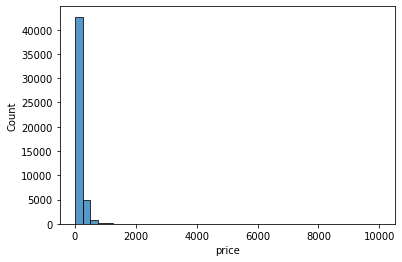

In [5]:
sns.histplot(df.price, bins=40)

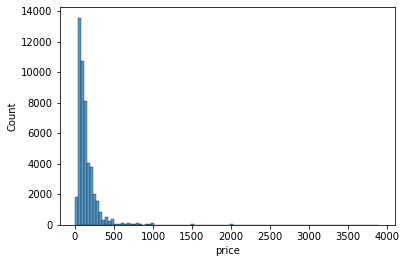

In [6]:
sns.histplot(df[df.price < 4000].price, bins=100)

The price variable has a long tail, as seen in the above histograms. This will likely be a problem for our linear regression model, so we'll have to take the logarithm of price as our target variable.

In [7]:
features = ['latitude', 'longitude', 'price', 'minimum_nights', 
            'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365']
df_full = df[features]
df_full.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


In [41]:
df_full.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Q1: The reviews_per_month variable has 10052 missing values.

In [9]:
df.minimum_nights.median()

3.0

Q2: Median of minimum_nights = 3.0

## **Defining Train, Validation, Test Dataframes**

In [10]:
np.random.seed(42)
idx = np.arange(len(df_full))
np.random.shuffle(idx)
idx

array([  879, 44383, 15394, ..., 38158,   860, 15795])

In [11]:
n_train = round(0.6*len(df_full))
n_val = round(0.2*len(df_full))
n_test = len(df_full) - n_train - n_val

n_train, n_val, n_test

(29337, 9779, 9779)

In [13]:
df_train = df_full.iloc[idx[:n_train]]
df_val = df_full.iloc[idx[n_train:n_train+n_val]]
df_test = df_full.iloc[idx[n_train+n_val:]]

In [14]:
y_train = df_train.price
y_val = df_val.price
y_test = df_test.price

del df_train['price']
del df_val['price']
del df_test['price']

In [15]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

In [17]:
def train_linear_regression(X, y):
  X = np.column_stack([np.ones(X.shape[0]), X])
  XTX = X.T.dot(X)
  return np.linalg.inv(XTX).dot(X.T.dot(y))

In [20]:
weights_zero_filled = train_linear_regression(df_train.fillna(0), y_train)
weights_mean_filled = train_linear_regression(df_train.fillna(df_train.reviews_per_month.mean()), y_train)

In [21]:
def linear_regression(X, weights):
  X = np.column_stack([np.ones(X.shape[0]), X])
  return X.dot(weights.T)

In [22]:
y_pred_0_val = linear_regression(df_val.fillna(0), weights_zero_filled)
y_pred_mean_val = linear_regression(df_val.fillna(df_train.reviews_per_month.mean()), weights_mean_filled)

In [24]:
y_pred_0_val, y_pred_mean_val

(array([4.57853272, 4.48375565, 4.73586366, ..., 4.77182321, 4.75592015,
        4.78192005]),
 array([4.56404917, 4.47586466, 4.72706725, ..., 4.7627167 , 4.74761535,
        4.81081466]))

In [25]:
def rmse(y_pred, y):
  return np.sqrt(((y_pred-y)**2).mean())

In [28]:
print('zero-filled, rmse =', round(rmse(y_pred_0_val, y_val), 2))
print('mean-filled, rmse = ', round(rmse(y_pred_mean_val, y_val), 2))

zero-filled, rmse = 0.64
mean-filled, rmse =  0.64


In [27]:
print('zero-filled, rmse =', rmse(y_pred_0_val, y_val))
print('mean-filled, rmse = ', rmse(y_pred_mean_val, y_val))

zero-filled, rmse = 0.6430337788657106
mean-filled, rmse =  0.6427545031726932


Q3: It looks like the mean-filled method yields only a slightly better rmse than the zero-filled method, so either method should work fine for our purposes.

In [32]:
def train_linear_regression_reg(X, y, r):
  X = np.column_stack([np.ones(X.shape[0]), X])
  XTX = X.T.dot(X)
  XTX += r*np.eye(XTX.shape[0])
  return np.linalg.inv(XTX).dot(X.T.dot(y))

# Regularization

In [30]:
reg_vals = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [35]:
for r in reg_vals:
  weights = train_linear_regression_reg(df_train.fillna(0), y_train, r)
  y_pred_val = linear_regression(df_val.fillna(0), weights)
  print("For r = {}, rmse = {}".format(r, round(rmse(y_pred_val, y_val), 2)))

For r = 0, rmse = 0.64
For r = 1e-06, rmse = 0.64
For r = 0.0001, rmse = 0.64
For r = 0.001, rmse = 0.64
For r = 0.01, rmse = 0.66
For r = 0.1, rmse = 0.68
For r = 1, rmse = 0.68
For r = 5, rmse = 0.68
For r = 10, rmse = 0.68


Q4: Several values of r give the lowest observed rmse, so the best r can be chosen to be 0.

# Testing Effect of Seed Value on RMSE

In [43]:
seed_val = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_scores = []

for seed in seed_val:
  np.random.seed(seed)
  idx = np.arange(len(df_full))
  np.random.shuffle(idx)
  
  df_train_seed = df_full.iloc[idx[:n_train]]
  df_val_seed = df_full.iloc[idx[n_train:n_train+n_val]]
  df_test_seed = df_full.iloc[idx[n_train+n_val:]]

  y_train_seed = df_train_seed.price
  y_val_seed = df_val_seed.price
  y_test_seed = df_test_seed.price

  del df_train_seed['price']
  del df_val_seed['price']
  del df_test_seed['price']

  y_train_seed = np.log1p(y_train_seed)
  y_val_seed = np.log1p(y_val_seed)
  y_test_seed = np.log1p(y_test_seed)

  weights_seed = train_linear_regression(df_train_seed.fillna(0), y_train_seed)
  y_pred_val_seed = linear_regression(df_val_seed.fillna(0), weights_seed)

  rmse_scores.append(rmse(y_pred_val_seed, y_val_seed))

np.std(rmse_scores)

0.007932965993554688

Q5: The standard deviation of the rmse scores using different random seeds is very low, so our model is stable.

In [46]:
np.random.seed(9)
idx = np.arange(len(df_full))
np.random.shuffle(idx)
  
df_train_final = df_full.iloc[idx[:n_train]]
df_val_final = df_full.iloc[idx[n_train:n_train+n_val]]
df_test_final = df_full.iloc[idx[n_train+n_val:]]

df_full_train = pd.concat([df_train_final, df_val_final])
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train.price
y_test_final = df_test_final.price

del df_full_train['price']
del df_test_final['price']

y_full_train = np.log1p(y_full_train)
y_test_final = np.log1p(y_test_final)

weights_final = train_linear_regression_reg(df_full_train.fillna(0), y_full_train, 0.001)
y_pred_test_final = linear_regression(df_test_final.fillna(0), weights_final)

print("The final rmse on the test dataset after training on the training and validation datasets with regularization of 0.001 = {}".format(rmse(y_pred_test_final, y_test_final)))

The final rmse on the test dataset after training on the training and validation datasets with regularization of 0.001 = 0.6452771348529895
